*Наблюдается внезапное падение активной аудитории. Нужно разобраться, какие пользователи не смогли зайти в приложение, что их объединяет?*

**Выводы - в конце файла**

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:title={'center':'1. DAU'}, xlabel='Day', ylabel='Number of Users'>

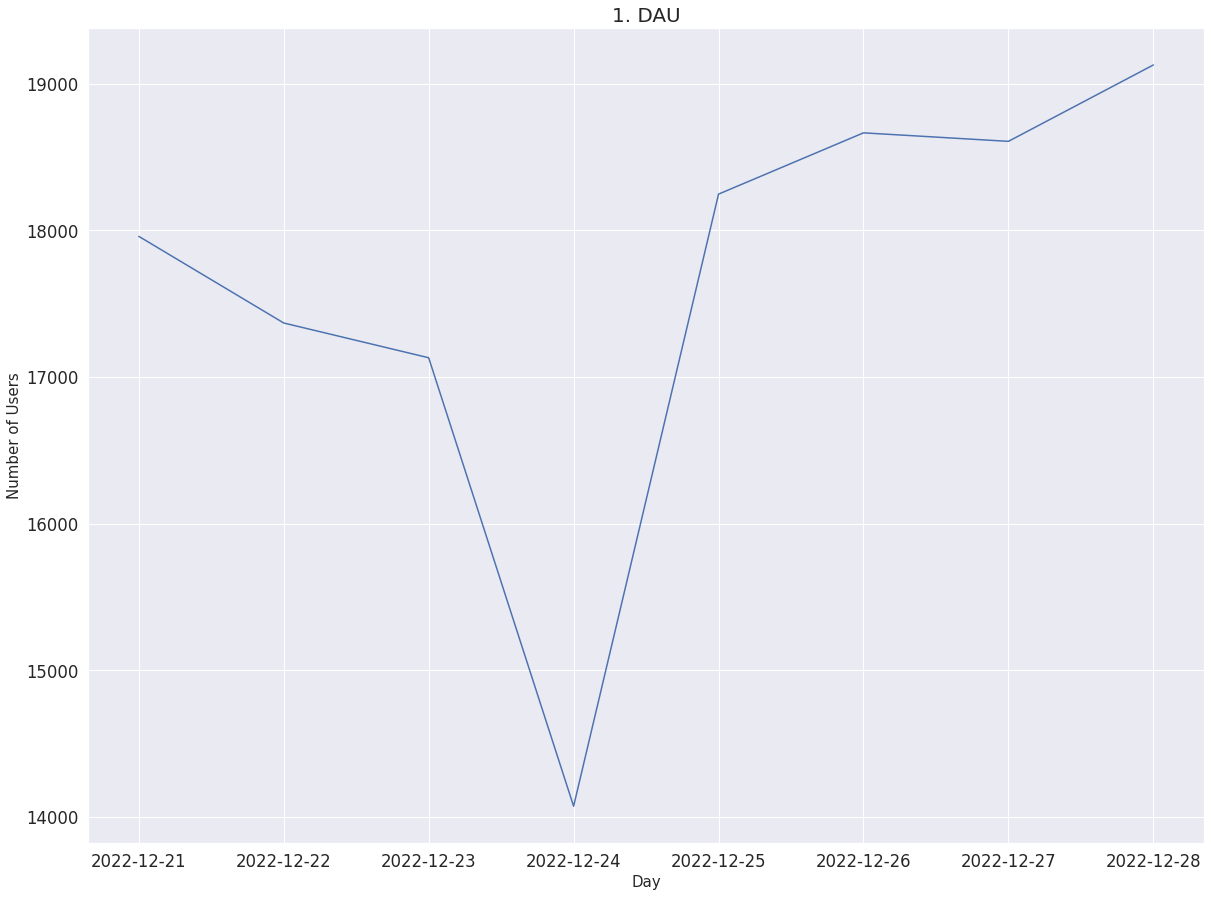

In [2]:
# отберём данные за неделю с 21 по 28 декабря 2022 года

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# запрос на подсчёт DAU
query_dau = '''
SELECT DATE(time) AS date, COUNT(DISTINCT user_id) AS active_users
FROM simulator_20221220.feed_actions
WHERE toDate(time) between '2022-12-21' and '2022-12-28'
GROUP BY DATE(time)
ORDER BY 1
'''

# строим график DAU
dau = ph.read_clickhouse(query_dau, connection=connection)
plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)
plt.title('1. DAU', fontsize=20)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Number of Users', fontsize=15)
sns.lineplot(data=dau, x='date', y='active_users')

Падение наблюдается 24 декабря 2022 года. Построим график DAU с разбивкой по активным странам.

In [ ]:
# запрос на подсчёт DAU с разбивкой по стране
query_dau_c = '''
SELECT toStartOfDay(toDateTime(time)) AS date,
       country AS country,
       count(DISTINCT user_id) AS active_users
FROM simulator_20221220.feed_actions
WHERE toDate(time) between '2022-12-21' and '2022-12-28'
GROUP BY country,
         toStartOfDay(toDateTime(time))
ORDER BY active_users DESC
'''

# строим график DAU с разбивкой по стране
dau_c = ph.read_clickhouse(query_dau_c, connection=connection)
plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)
plt.title('2. DAU by Country', fontsize=20)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Number of Users', fontsize=15)
sns.lineplot(data=dau_c, x='date', y='active_users', hue='country')

Видим, что падение прежде всего характерно для пользователей из России. Посмотрим на DAU по странам без включения России - наблюдается ли падение у них?

In [ ]:
# запрос на подсчёт DAU с разбивкой по стране (не включаем Россию)
query_dau_c_nr = '''
SELECT toStartOfDay(toDateTime(time)) AS date,
       country AS country,
       count(DISTINCT user_id) AS active_users
FROM simulator_20221220.feed_actions
WHERE toDate(time) between '2022-12-21' and '2022-12-28' AND country != 'Russia'
GROUP BY country,
         toStartOfDay(toDateTime(time))
ORDER BY active_users DESC
'''

# строим график DAU с разбивкой по стране (не включаем Россию)
dau_c_nr = ph.read_clickhouse(query_dau_c_nr, connection=connection)
plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)
plt.title('3. DAU by Country (without Russia)', fontsize=20)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Number of Users', fontsize=15)
sns.lineplot(data=dau_c_nr, x='date', y='active_users', hue='country')

Остальные страны не показали значительных провалов в DAU. Посмотрим на DAU в 10 самых популярных городах России.

In [ ]:
# запрос на подсчёт DAU в топ-10 городов России по активности с 23 по 25 декабря 2022 года
query_dau_top_10 = '''
SELECT toStartOfDay(toDateTime(time)) AS date,
       city AS city,
       count(DISTINCT user_id) AS active_users
FROM
  (WITH tops AS
     (SELECT COUNT (DISTINCT user_id) AS users,
                   city
      FROM simulator_20221220.feed_actions
      WHERE country = 'Russia'
      GROUP BY city
      ORDER BY users DESC
      LIMIT 10) SELECT *
   FROM simulator_20221220.feed_actions
   WHERE city IN
       (SELECT city
        FROM tops)) AS virtual_table
WHERE toDate(time) between '2022-12-23' and '2022-12-25'
GROUP BY city,
         toStartOfDay(toDateTime(time))
ORDER BY active_users DESC
'''

dau_top_10 = ph.read_clickhouse(query_dau_top_10, connection=connection)
dau_top_10.head()

In [ ]:
# посмотрим на список уникальных городов
dau_top_10.city.unique()

In [ ]:
# посмотрим на данные от 4 декабря 2022 года - всего 6 городовиз 10
dau_top_10[dau_top_10.date == '2022-12-24']

# Выводы

- График 1 (DAU) - отмечается падение до 14.1K активных пользователей 24 декабря 2022.
- На графиках 2 и 3 видим, что падение прежде всего характерно для пользователей из России (остальные страны не показали значительных провалов). Однако россияне составляют абсолютное большинство общего числа юзеров, что может быть означать не локальный, а глобальный сбой в приложении.
- Тем не менее есть свидетельство, что не смогли зайти пользователи 4 городов из топ-10 городов России, а именно: Москвы, Санкт-Петербурга, Екатеринбурга, Новосибирска.

Таким образом, 24 декабря 2022 года в первую очередь не смогли зайти пользователи городов России, входящих в топ городов по активным пользователям. Например, Москва и Санкт-Петербург - безусловные лидеры этого топа.